### Module Import

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
from sklearn import model_selection, metrics

In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from tensorflow.python.client import device_lib
import keras.backend.tensorflow_backend as K
from keras import layers, models

### Raw data reading

In [7]:
raw_data = pd.read_csv('/home/dmlab/.jupyter/DMLAB/jihoon/DMLAB/2020JIPS/Data/Rawdata.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], 
                                           axis=1)
raw_data

,Author,HotelInfo.HotelID,Service,Cleanliness,Value,Sleep Quality,Rooms,Location,Content,Date
0,Clara79,280518,3,3,4,4.0,3.0,3.0,"['hotel', 'bit', 'surprise', 'could', 'find', ...","September 22, 2004"
1,BerlinerPooh,280518,1,1,1,1.0,0.0,1.0,"['room', 'adequate', 'little', 'drab', 'side',...","January 18, 2005"
2,amazingthing,280518,2,4,3,4.0,3.0,3.0,"['first', 'read', 'review', 'side', 'booking',...","May 10, 2005"
3,Nitus,280518,4,4,5,5.0,0.0,0.0,"['one', 'night', 'stay', 'artus', 'hotel', 'be...","October 23, 2005"
4,mattp1874,280518,4,5,4,5.0,4.0,5.0,"['stayed', 'hotel', 'night', 'ok', 'missing', ...","March 12, 2007"
...,...,...,...,...,...,...,...,...,...,...
355167,Posted by an Accorhotels.com traveler,289861,3,4,3,0.0,4.0,2.0,"['stayed', 'week', 'rustica', 'child', 'year',...","October 28, 2011"
355168,Posted by an Accorhotels.com traveler,289861,3,4,5,0.0,4.0,1.0,"['superb', 'stay', 'novotel', 'although', 'out...","November 4, 2011"
355169,paulpowell3540,289861,4,5,4,0.0,5.0,0.0,"['yes', 'distance', 'rome', 'however', 'hotel'...","November 10, 2011"
355170,uclabobby,289861,5,5,5,0.0,5.0,0.0,"['hotel', 'nice', 'look', 'nice', 'room', 'com...","January 2, 2012"


In [8]:
content_list = np.array(raw_data['Content'].tolist())
content_list

array(["['hotel', 'bit', 'surprise', 'could', 'find', 'review', 'anywhere', 'however', 'turned', 'entirely', 'pleasant', 'one', 'location', 'great', 'close', 'ku', 'damn', 'charlottenburg', 'literally', 'next', 'berliner', 'strasse', 'u', 'bahn', 'staff', 'excellent', 'willing', 'help', 'bunch', 'english', 'direction', 'good', 'restaurant', 'club', 'hour', 'room', 'huge', 'expected', 'bedroom', 'bathroom', 'got', 'luxurious', 'lounge', 'little', 'kitchen', 'would', 'highly', 'recommend', 'hotel', 'anyone', 'paid', 'le', 'twin', 'room', 'pity', 'could', 'stay', 'longer', 'appreciate', 'berlin', 'great', 'hotel']",
       "['room', 'adequate', 'little', 'drab', 'side', 'noisy', 'main', 'street', 'front', 'kitchenette', 'removed', 'used', 'area', 'storing', 'luggage', 'shopping', 'underground', 'road', 'another', 'across', 'street', 'take', 'time', 'reach', 'fabulous', 'shop', 'restaurant', 'busy', 'area', 'ku', 'damm', 'main', 'entrance', 'hotel', 'rather', 'grand', 'adjacent', 'large', 

### Data Tokenizing & word_indexing

In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(content_list)
tokenizer.word_index

{"'room'": 1,
 "'hotel'": 2,
 "'great'": 3,
 "'stay'": 4,
 "'would'": 5,
 "'staff'": 6,
 "'good'": 7,
 "'night'": 8,
 "'one'": 9,
 "'time'": 10,
 "'u'": 11,
 "'nice'": 12,
 "'day'": 13,
 "'stayed'": 14,
 "'get'": 15,
 "'location'": 16,
 "'clean'": 17,
 "'service'": 18,
 "'breakfast'": 19,
 "'bed'": 20,
 "'pool'": 21,
 "'also'": 22,
 "'place'": 23,
 "'restaurant'": 24,
 "'like'": 25,
 "'area'": 26,
 "'well'": 27,
 "'really'": 28,
 "'could'": 29,
 "'back'": 30,
 "'go'": 31,
 "'small'": 32,
 "'bathroom'": 33,
 "'friendly'": 34,
 "'food'": 35,
 "'walk'": 36,
 "'view'": 37,
 "'floor'": 38,
 "'even'": 39,
 "'two'": 40,
 "'check'": 41,
 "'desk'": 42,
 "'minute'": 43,
 "'got'": 44,
 "'helpful'": 45,
 "'resort'": 46,
 "'comfortable'": 47,
 "'front'": 48,
 "'much'": 49,
 "'little'": 50,
 "'bar'": 51,
 "'first'": 52,
 "'free'": 53,
 "'people'": 54,
 "'price'": 55,
 "'next'": 56,
 "'around'": 57,
 "'lot'": 58,
 "'right'": 59,
 "'trip'": 60,
 "'beach'": 61,
 "'thing'": 62,
 "'best'": 63,
 "'excelle

In [10]:
ipc_Xdata = np.array(tokenizer.texts_to_sequences(content_list))
print(ipc_Xdata)
print(ipc_Xdata.shape)

[list([2, 85, 768, 29, 107, 89, 478, 100, 583, 2917, 292, 9, 16, 3, 69, 8527, 5183, 16683, 829, 56, 15841, 9789, 11, 3313, 6, 64, 1109, 279, 2036, 466, 610, 7, 24, 270, 97, 1, 199, 399, 235, 33, 44, 980, 361, 50, 368, 5, 309, 65, 2, 312, 252, 254, 973, 1, 4054, 29, 4, 840, 1629, 1730, 3, 2])
 list([1, 569, 50, 4249, 157, 404, 208, 66, 48, 1354, 1807, 194, 26, 4084, 355, 234, 1264, 350, 124, 211, 66, 87, 10, 1390, 526, 212, 24, 342, 26, 8527, 9059, 208, 607, 2, 406, 379, 1366, 84, 4581, 51, 26, 19, 196, 267, 6, 34, 587, 50, 667, 24, 43, 70, 552, 63, 867, 178, 1201, 101, 68, 30])
 list([52, 341, 89, 157, 392, 138, 114, 298, 1, 44, 9, 207, 70, 208, 350, 140, 300, 50, 99, 235, 562, 585, 1, 44, 1354, 27, 243, 1, 8, 746, 2, 1730, 103, 375, 1877, 2, 85, 2063, 533, 56, 273, 136, 87, 256, 1633, 16256, 17918, 34760, 1514, 2, 6, 45, 5, 2698, 296, 56, 1730, 4, 2])
 ...
 list([372, 197, 445, 100, 2, 420, 375, 289, 181, 3190, 259, 10, 13, 479, 445, 1, 1220, 17, 3, 33, 1904, 26, 556, 2823, 796, 100, 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [11]:
ipc_Ydata = np.array(raw_data[['Service', 'Cleanliness','Value',
                               'Sleep Quality','Rooms','Location']])
print(ipc_Ydata)
print(ipc_Ydata.shape)

[[3. 3. 4. 4. 3. 3.]
 [1. 1. 1. 1. 0. 1.]
 [2. 4. 3. 4. 3. 3.]
 ...
 [4. 5. 4. 0. 5. 0.]
 [5. 5. 5. 0. 5. 0.]
 [4. 5. 3. 0. 5. 0.]]
(355172, 6)


### Data Split & Get maxlen and max_features

In [12]:
train_x, test_x, train_y, test_y = train_test_split(ipc_Xdata, ipc_Ydata, 
                                                    test_size=0.3)
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

(248620,) (106552,) (248620, 6) (106552, 6)


In [13]:
maxlen = 1
max_features = 1
for idx in ipc_Xdata :
    try :
        len_ = len(idx) #print(idx)
        max_ = np.max(idx)
    except :
        #print(idx)
        continue
    #print(type(max_))
    #break
    if max_features < max_ :
        max_features = max_
    if maxlen < len_ :
        maxlen = len_
print(maxlen)
print(max_features)

2670
148649


### Model building

#### Padding

In [15]:
print('Loading data...')

print(len(train_x), 'train sequences')
print(len(test_x), 'test sequences')

print(train_x.shape, test_x.shape, train_y.shape, test_y.shape)

print('Pad sequences (samples x time)')

train_x = sequence.pad_sequences(train_x, maxlen=maxlen)
test_x = sequence.pad_sequences(test_x, maxlen=maxlen)
print('train_x shape:', train_x.shape)
print('test_x shape:', test_x.shape)

Loading data...
248620 train sequences
106552 test sequences
(248620,) (106552,) (248620, 6) (106552, 6)
Pad sequences (samples x time)
train_x shape: (248620, 2670)
test_x shape: (106552, 2670)


#### variables setting

In [244]:
# Embedding
max_features = 148650 # feature 값 변경
maxlen = 2670 # 리뷰의 길이
embedding_size = 128

# Convolution
kernel_size = 5 # 1
filters = 128 # 256
pool_size = 4

# LSTM
lstm_output_size = 10

# Training
batch_size = 500 # 310 #30 -> 20
epochs = 10

#### Model Building

In [298]:
print('Build model...')
#model = Sequential()
input_layer = layers.Input((maxlen,))

embedding_layer = layers.Embedding(max_features, 64)(input_layer)

convolution_layer = layers.Conv1D(32, 3, padding = 'valid',
                                 activation='relu', strides=1)(embedding_layer)

maxpooling_layer = layers.MaxPooling1D(pool_size)(convolution_layer)

lstm_layer = layers.Bidirectional(layers.CuDNNLSTM(16, return_sequences=True))(maxpooling_layer)

dropout_layer = layers.Dropout(0.25)(lstm_layer) 

flatten_layer = layers.Flatten()(dropout_layer)

output_layer1 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer2 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer3 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer4 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer5 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)
output_layer6 = layers.Dense(1, activation = 'sigmoid')(flatten_layer)

model = models.Model(inputs=input_layer, outputs=
                     [output_layer1, output_layer2, output_layer3, output_layer4,
                      output_layer5, output_layer6])
model.summary()

model.compile(loss='mse', 
              optimizer='rmsprop',
              metrics=['accuracy'])

Build model...
Model: "model_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_47 (InputLayer)           (None, 2670)         0                                            
__________________________________________________________________________________________________
embedding_47 (Embedding)        (None, 2670, 64)     9513600     input_47[0][0]                   
__________________________________________________________________________________________________
conv1d_47 (Conv1D)              (None, 2668, 32)     6176        embedding_47[0][0]               
__________________________________________________________________________________________________
max_pooling1d_47 (MaxPooling1D) (None, 667, 32)      0           conv1d_47[0][0]                  
____________________________________________________________________________

#### Train

In [299]:
with K.tf.device('/gpu:0'):
    print('Train...')
    hist = model.fit(train_x, [train_y[:,0]/5, train_y[:,1]/5, 
                               train_y[:,2]/5, train_y[:,3]/5, 
                               train_y[:,4]/5, train_y[:,5]/5],
                     batch_size=batch_size,
                     epochs=epochs)
    
   # score, acc = model.evaluate(test_x, test_y[:,0:6], 
   #                             batch_size=batch_size)
    
    score = model.evaluate(test_x, [test_y[:,0]/5, test_y[:,1]/5,
                                     test_y[:,2]/5, test_y[:,3]/5,
                                     test_y[:,4]/5, test_y[:,5]/5], 
                            batch_size = batch_size)
    
    predicted = model.predict(test_x)
    
    print('Test score:', score)
    print('Test accuracy:', acc)

Train...
Epoch 1/10
248620/248620 [==============================] - 49s 198us/step - loss: 0.7997 - dense_82_loss: 0.1080 - dense_83_loss: 0.1036 - dense_84_loss: 0.1055 - dense_85_loss: 0.1885 - dense_86_loss: 0.1328 - dense_87_loss: 0.1612 - dense_82_acc: 0.4312 - dense_83_acc: 0.4843 - dense_84_acc: 0.3733 - dense_85_acc: 0.5061 - dense_86_acc: 0.3198 - dense_87_acc: 0.4529
Epoch 2/10
248620/248620 [==============================] - 46s 184us/step - loss: 0.7703 - dense_82_loss: 0.1034 - dense_83_loss: 0.0989 - dense_84_loss: 0.1018 - dense_85_loss: 0.1793 - dense_86_loss: 0.1288 - dense_87_loss: 0.1581 - dense_82_acc: 0.4334 - dense_83_acc: 0.4865 - dense_84_acc: 0.3743 - dense_85_acc: 0.5191 - dense_86_acc: 0.3250 - dense_87_acc: 0.4541
Epoch 3/10
248620/248620 [==============================] - 46s 185us/step - loss: 0.7408 - dense_82_loss: 0.0996 - dense_83_loss: 0.0950 - dense_84_loss: 0.0981 - dense_85_loss: 0.1699 - dense_86_loss: 0.1243 - dense_87_loss: 0.1539 - dense_82_ac

In [300]:
print(len(test_x))
print(len(predicted))
arr_predicted = np.array(predicted)
print(arr_predicted.shape)
print(arr_predicted)

arr = np.squeeze(arr_predicted, 2)
arr = np.transpose(arr)
print(arr.shape)
print('times 5')
# print(arr)
arr = arr * 5
arr = arr.astype('int64')
print(arr.shape)
print(arr)

106552
6
(6, 106552, 1)
[[[0.8592919 ]
  [0.97061586]
  [0.4303944 ]
  ...
  [0.6024704 ]
  [0.60534704]
  [0.7753869 ]]

 [[0.8954282 ]
  [0.98320365]
  [0.47058764]
  ...
  [0.6630765 ]
  [0.64608413]
  [0.8188876 ]]

 [[0.8355185 ]
  [0.96140504]
  [0.4136018 ]
  ...
  [0.58689547]
  [0.58991843]
  [0.74664307]]

 [[0.55143917]
  [0.3893994 ]
  [0.18351918]
  ...
  [0.14845264]
  [0.3074886 ]
  [0.42184734]]

 [[0.7449405 ]
  [0.9759921 ]
  [0.32433334]
  ...
  [0.47730592]
  [0.46493435]
  [0.6785002 ]]

 [[0.73997873]
  [0.9834486 ]
  [0.37511244]
  ...
  [0.4286297 ]
  [0.49787092]
  [0.7070322 ]]]
(106552, 6)
times 5
(106552, 6)
[[4 4 4 2 3 3]
 [4 4 4 1 4 4]
 [2 2 2 0 1 1]
 ...
 [3 3 2 0 2 2]
 [3 3 2 1 2 2]
 [3 4 3 2 3 3]]


In [301]:
print(test_y[0])
print(arr[0])

[5. 5. 4. 0. 5. 5.]
[4 4 4 2 3 3]


#### Learning process graph

KeyError: 'acc'

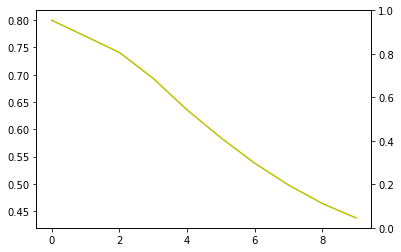

In [302]:
fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')

acc_ax.plot(hist.history['acc'], 'b', label='train acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()
    